In [1]:
import pandas as pd
import numpy as np
import regex as re

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read in data

In [2]:
features = pd.read_csv('train_merge_all.csv')
features = features.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)

In [3]:
features.head()

,Date,Species,Trap,Longitude,Latitude,Tmax,Tmin,Tavg,Depart,DewPoint,...,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,DaysFromSpray,LogDays,SprayEffect
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,-87.800991,41.954690,78.9,57.3,68.3,5.7,49.0,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
1,2007-05-29,CULEX RESTUANS,T002,-87.800991,41.954690,78.9,57.3,68.3,5.7,49.0,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
2,2007-05-29,CULEX RESTUANS,T007,-87.769279,41.994991,78.9,57.3,68.3,5.7,49.0,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,-87.824812,41.974089,78.9,57.3,68.3,5.7,49.0,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0
4,2007-05-29,CULEX RESTUANS,T015,-87.824812,41.974089,78.9,57.3,68.3,5.7,49.0,...,0.0,0.1,29.4,30.1,8.0,15.9,9.8,1500.0,7.313887,0.0


In [4]:
features.shape

(10506, 28)

In [5]:
target = pd.read_csv('target.csv')
target.head()

,WnvPresent
0,0
1,0
2,0
3,0
4,0


In [6]:
target.shape

(10506, 1)

### Train-test-split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify = target, random_state=42)

In [8]:
# baseline accuracy
print(y_train['WnvPresent'].value_counts())
print('\nBaseline accuracy: '+str(max(y_train['WnvPresent'].value_counts()/y_train.shape[0])))

0    7466
1     413
Name: WnvPresent, dtype: int64

Baseline accuracy: 0.9475821804797563


In [9]:
## note classes are extremely unbalanced - come back to this later

### Feature exploration

In [10]:
X_train.columns

Index(['Date', 'Species', 'Trap', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise',
       'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'DaysFromSpray', 'LogDays', 'SprayEffect'],
      dtype='object')

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7879 entries, 10140 to 6831
Data columns (total 28 columns):
Date             7879 non-null object
Species          7879 non-null object
Trap             7879 non-null object
Longitude        7879 non-null float64
Latitude         7879 non-null float64
Tmax             7879 non-null float64
Tmin             7879 non-null float64
Tavg             7879 non-null float64
Depart           7879 non-null float64
DewPoint         7879 non-null float64
WetBulb          7879 non-null float64
Heat             7879 non-null float64
Cool             7879 non-null float64
Sunrise          7879 non-null float64
Sunset           7879 non-null float64
CodeSum          7879 non-null object
Depth            7879 non-null float64
Water1           7879 non-null float64
SnowFall         7879 non-null float64
PrecipTotal      7879 non-null float64
StnPressure      7879 non-null float64
SeaLevel         7879 non-null float64
ResultSpeed      7879 non-null floa

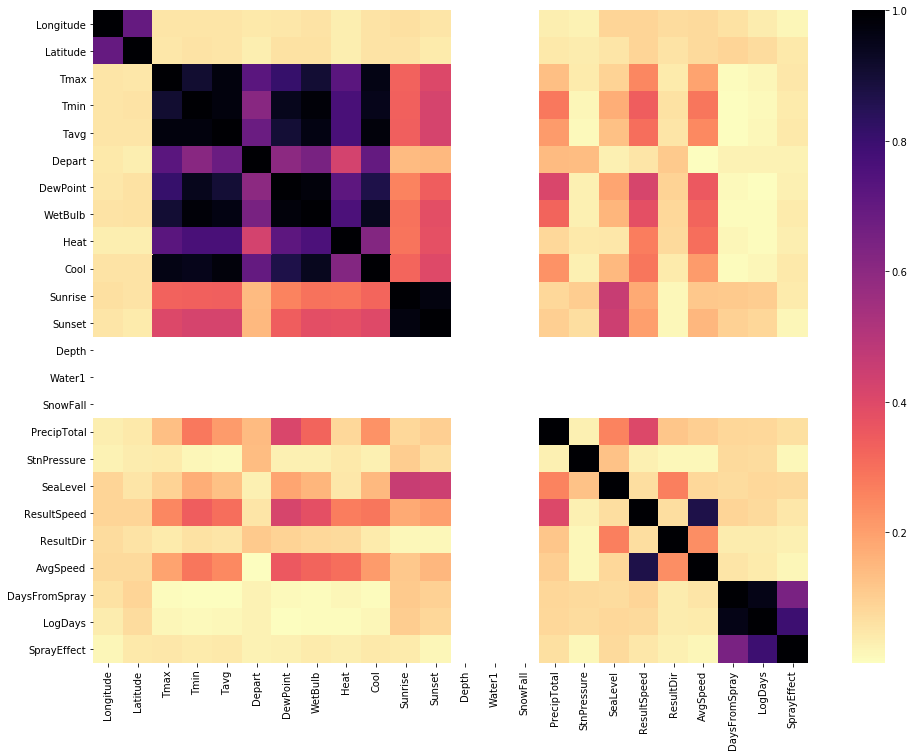

In [12]:
# look at correlation between numerical features
fig = plt.figure(figsize=(16,12))
sns.heatmap(abs(X_train.corr()),cmap='magma_r', )

In [13]:
# investigate gaps in heatmap
print(X_train['Depth'].value_counts(),'\n')
print(X_train['Water1'].value_counts(),'\n')
print(X_train['SnowFall'].value_counts(),'\n')

0.0    7879
Name: Depth, dtype: int64 

0.0    7879
Name: Water1, dtype: int64 

0.0    7879
Name: SnowFall, dtype: int64 



In [14]:
## drop these features
drop_features = ['Depth','Water1','SnowFall']

In [15]:
# some groups are highly correlation with each other, so only keep one feature in each group
# however, want to check which will be best predictor of WNV
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_train, y_train], axis=1)

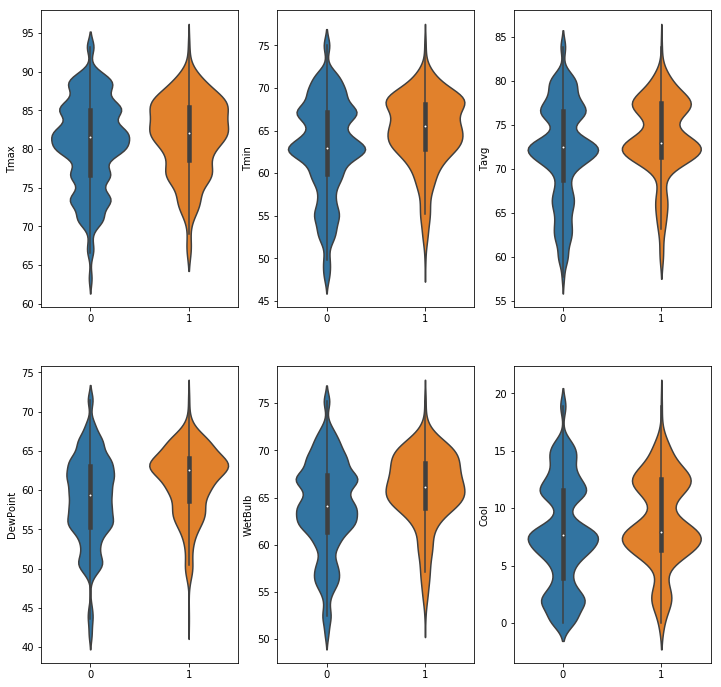

In [16]:
# group 1: Tmax, Tmin, Tavg, DewPoint, WetBulb, Cool
fig = plt.figure(figsize=(12,12))
for i, feature in enumerate(['Tmax','Tmin','Tavg','DewPoint','WetBulb','Cool']):
    ax = fig.add_subplot(2, 3, i+1)
    sns.violinplot(y=feature, x='WnvPresent', data=train)
    plt.suptitle('')
    plt.tight_layout
    ax.set_xlabel('')

In [17]:
## keep dew point, Tmin and WetBulb - shows most variation between classes
drop_features.extend(['Tmax','Tmin','Tavg','Cool'])

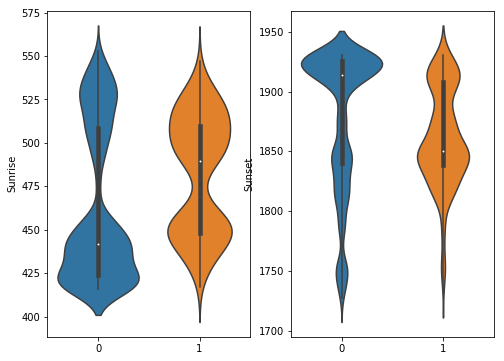

In [18]:
# group 2: Sunrise, Sunset
fig = plt.figure(figsize=(8,6))
for i, feature in enumerate(['Sunrise','Sunset']):
    ax = fig.add_subplot(1, 2, i+1)
    sns.violinplot(y=feature, x='WnvPresent', data=train)
    plt.suptitle('')
    plt.tight_layout
    ax.set_xlabel('')

In [19]:
## shows more likely to get WNV when days are shorter - could engineer feature on day length

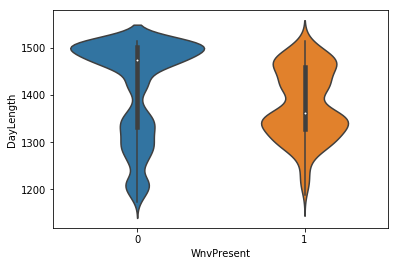

In [20]:
train['DayLength'] = train['Sunset'] - train['Sunrise']
sns.violinplot(y='DayLength', x='WnvPresent', data=train);

In [21]:
## looks as/less helpful than just Sunset
## sunset shows most variation between classes
## keep both for now - dropping it seems to make the model worse
#drop_features.extend(['Sunrise'])

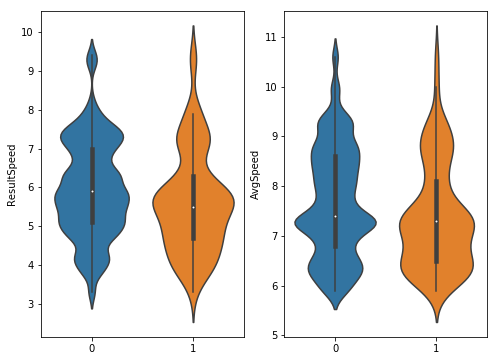

In [22]:
# group 3: ResultSpeed, AvgSpeed
fig = plt.figure(figsize=(8,6))
for i, feature in enumerate(['ResultSpeed','AvgSpeed']):
    ax = fig.add_subplot(1, 2, i+1)
    sns.violinplot(y=feature, x='WnvPresent', data=train)
    plt.suptitle('')
    plt.tight_layout
    ax.set_xlabel('')

In [23]:
## result speed shows most variation between classes
## keep both for now - dropping it seems to make the model worse
#drop_features.extend(['AvgSpeed'])

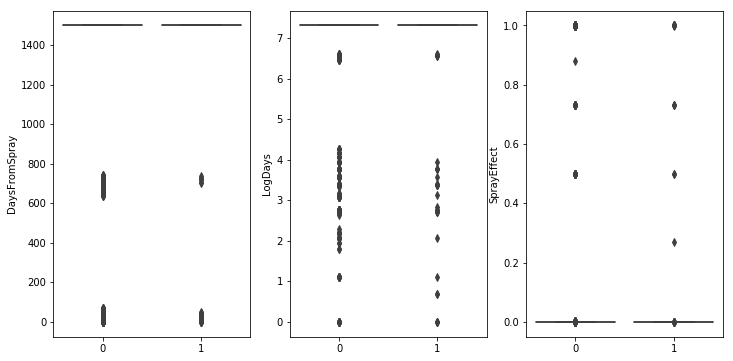

In [24]:
# group 4: DaysFromSpray, LogDays, SprayEffect
fig = plt.figure(figsize=(12,6))
for i, feature in enumerate(['DaysFromSpray','LogDays','SprayEffect']):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(y=feature, x='WnvPresent', data=train)
    plt.suptitle('')
    plt.tight_layout
    ax.set_xlabel('')

In [25]:
## keep SprayEffect
drop_features.extend(['LogDays','DaysFromSpray'])

In [26]:
X_train.drop(columns=drop_features).head(2)

,Date,Species,Trap,Longitude,Latitude,Depart,DewPoint,WetBulb,Heat,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,SprayEffect
10140,2013-09-06,CULEX PIPIENS,T225,-87.731435,41.743402,4.3,60.6,65.1,0.0,518.0,1825.7,"['TS', 'RA', 'BR', 'TSRA']",0.1,29.3,29.9,5.8,17.5,7.3,0.0
7737,2011-09-12,CULEX PIPIENS,T030,-87.716788,41.899230,-2.3,53.1,58.2,1.8,524.0,1815.4,"['FG+', 'RA', 'DZ', 'BR']",0.0,29.4,30.0,9.4,9.9,10.0,0.0


In [27]:
# check which mosquitos carry the virus
train.groupby('Species')['WnvPresent'].mean()

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.092150
CULEX PIPIENS/RESTUANS    0.053501
CULEX RESTUANS            0.016256
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

In [28]:
## only pipiens/restuans appear to carry the virus

In [29]:
# drop Trap ID
drop_features.append('Trap')

In [30]:
# function to prepare dataset for modeling

def process_features(df, drop_cols):
    
    df.loc[:,'Date'] = pd.to_datetime(df['Date'])
    df.loc[:,'Date'] = pd.to_numeric(df['Date'])
    df.drop(columns = drop_cols, inplace = True)

    #df = pd.get_dummies(df, columns=['Species'])
    
    # flag on mosiquto type - only pipiens/restuans appear to carry the virus
    carriers = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
    for carrier in carriers:
        df['Species_'+carrier] = df['Species'].map(lambda x: 1 if x==carrier else 0)
    #df['Species_OTHER'] = df['Species'].map(lambda x: 1 if x not in carriers else 0)
    df.drop(columns = ['Species'], inplace=True)
    
    # create dummies for weather codes
    
    # replace str object with list
    df.loc[:,'CodeSum'] = df['CodeSum'].map(lambda x: re.findall(r'([A-Z\+\-]+)', x))
    # find all unique codes in the dataframe
    codes = []
    for value in df['CodeSum'].values:
        codes.extend(value)  
    codes = set(codes)
    # add dummy flags for each unique code
    for code in codes:
        df[code] = df['CodeSum'].map(lambda x: 1 if code in x else 0)
        
    df.drop(columns='CodeSum', inplace = True)
        
    return df

In [31]:
X_train = process_features(X_train, drop_features)
X_test = process_features(X_test, drop_features)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

In [32]:
X_train.head()

,Date,Longitude,Latitude,Depart,DewPoint,WetBulb,Heat,Sunrise,Sunset,PrecipTotal,...,TS,RA,BCFG,GR,BR,FG+,HZ,VCFG,FU,MIFG
10140,1378425600000000000,-87.731435,41.743402,4.3,60.6,65.1,0.0,518.0,1825.7,0.1,...,1,1,0,0,1,0,0,0,0,0
7737,1315785600000000000,-87.716788,41.899230,-2.3,53.1,58.2,1.8,524.0,1815.4,0.0,...,0,1,0,0,1,1,0,0,0,0
8079,1317340800000000000,-87.562889,41.766202,-2.7,50.6,53.3,7.3,543.0,1742.4,0.3,...,0,1,0,0,1,0,0,0,0,0
2449,1187740800000000000,-87.585413,41.726465,-0.6,63.1,66.1,0.1,496.3,1849.3,0.4,...,1,1,0,0,1,0,1,0,0,0
449,1184716800000000000,-87.648860,41.862292,-1.6,55.4,62.0,0.0,428.4,1926.6,0.0,...,0,1,0,0,1,0,0,0,0,0


In [33]:
X_test.head()

,Date,Longitude,Latitude,Depart,DewPoint,WetBulb,Heat,Sunrise,Sunset,PrecipTotal,...,TS,RA,BCFG,GR,BR,FG+,HZ,VCFG,FU,MIFG
1554,1186444800000000000,-87.752329,41.918705,6.0,63.9,69.5,0.0,447.0,1909.1,0.2,...,1,1,0,0,1,0,1,0,0,0
3181,1189555200000000000,-87.565666,41.704572,5.3,59.4,64.1,0.7,524.0,1815.4,0.1,...,0,1,0,0,1,0,1,0,0,0
7921,1316131200000000000,-87.805059,41.973845,-1.1,53.1,58.3,3.6,528.0,1808.6,0.0,...,0,1,0,0,1,1,1,0,1,0
3536,1190592000000000000,-87.585487,41.799282,7.7,53.9,61.3,0.1,536.9,1752.9,0.0,...,0,0,0,0,0,0,1,0,0,0
3034,1189036800000000000,-87.585413,41.726465,4.0,57.4,63.9,0.0,518.0,1825.7,0.0,...,0,1,0,0,0,0,0,0,0,0


### Sample classes to balance them

In [34]:
# undersample where no WNV is present
np.random.seed(42)
indices = np.random.choice(y_train[y_train['WnvPresent']==0].index,size=6000, replace=False).tolist()

In [35]:
# oversample where WNV is present
indices.extend(np.random.choice(y_train[y_train['WnvPresent']==1].index,size=4000, replace=True).tolist())

In [36]:
X_train_bal = X_train.loc[indices,:]
y_train_bal = y_train.loc[indices,:]

### Model data - logistic regression

#### Baseline

Accuracy: 0.9474685953559193
ROC AUC: 0.5
Confusion matrix:


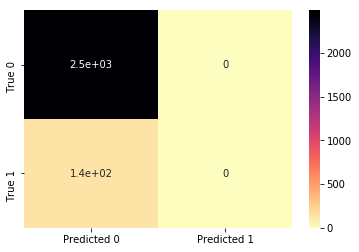

In [37]:
print('Accuracy:', max(y_test['WnvPresent'].value_counts()/y_test.shape[0]))

y_hat_prob1 = [0 for _ in range(y_test.shape[0])]
print('ROC AUC:', roc_auc_score(y_test, y_hat_prob1))

y_hat = [0 for _ in range(y_test.shape[0])]
print('Confusion matrix:')
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap='magma_r', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);

In [38]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

#### Unbalanced classes

GS best ROC AUC score: 0.8271105613690014
GS best params: {'lr__C': 8.75, 'lr__penalty': 'l1'}

Train accuracy: 0.9482167787790329
Test accuracy: 0.948229920060906

Test ROC AUC: 0.8199847444698702
Test confusion matrix:


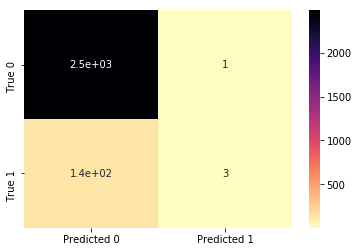

In [39]:
params  = {
    'lr__penalty': ['l1','l2'],
   'lr__C': np.linspace(8,9, 5)
}

gs = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc') # inputs: model, parameters to search over

gs.fit(X_train, y_train['WnvPresent'])

print('GS best ROC AUC score:',gs.best_score_) # best cv score
print('GS best params:',gs.best_params_)
print('')

y_hat_train = gs.predict(X_train)
print('Train accuracy:', accuracy_score(y_train, y_hat_train))
y_hat = gs.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_hat))
print('') 

print('Test ROC AUC:',gs.score(X_test, y_test['WnvPresent']))
print('Test confusion matrix:')
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, cmap='magma_r', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);

In [40]:
# look at parameters
betas = gs.best_estimator_.named_steps['lr'].coef_

coef_df = pd.DataFrame(betas.T, columns = ['coefs'], index = X_train_bal.columns)

coef_abs_df = pd.DataFrame(coef_df['coefs'].map(lambda x: abs(x)).sort_values(ascending=False))
coef_abs_df['sign'] = coef_df['coefs'].map(lambda x: 1 if x>0 else -1)
coef_abs_df.reset_index(inplace=True)

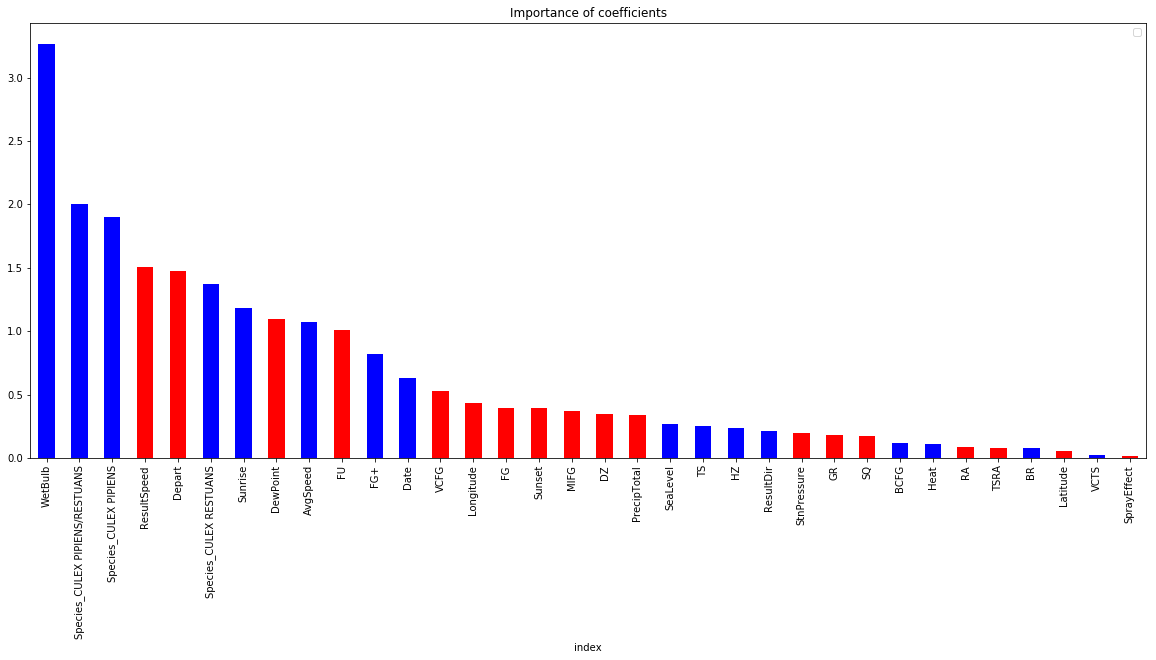

In [46]:
colors = coef_abs_df['sign'].map(lambda x: 'blue' if x==1 else 'red')
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
coef_abs_df.plot(x='index',y='coefs', kind='bar', color=colors, ax=ax)
ax.legend('')
ax.set_title('Importance of coefficients');

#### Changing threshold from unbalanced class model

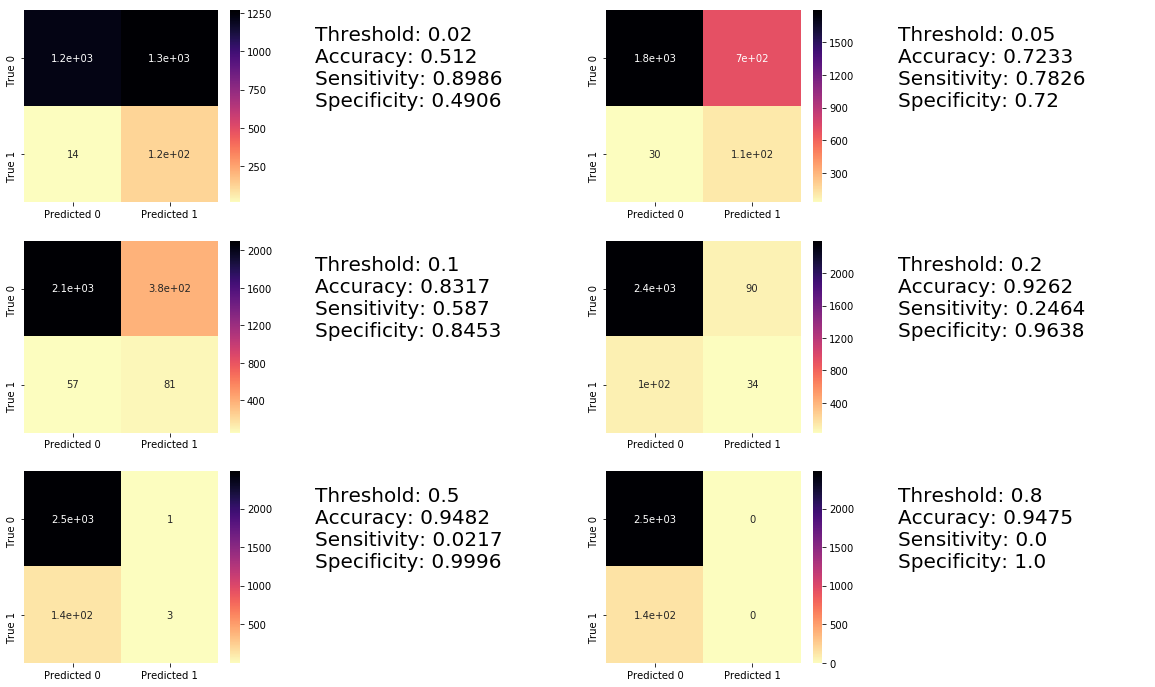

In [101]:
thresholds = [0.02,0.05,0.1, 0.2, 0.5, 0.8]

fig = plt.figure(figsize=(20, 12))

for i, threshold in enumerate(thresholds):
    pred = gs.predict_proba(X_test)
    y_test_hat = []
    for obs in range(len(pred)):
        if pred[obs][1] < threshold:
            y_test_hat.append(0)
        else:
            y_test_hat.append(1)

    ax = fig.add_subplot(3, 4, i*2+1)
    conf_mat = confusion_matrix(y_test, y_test_hat)
    sns.heatmap(conf_mat, annot=True, cmap='magma_r', 
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);
    
    ax = fig.add_subplot(3, 4, i*2+2)
    text = 'Threshold: '+str(threshold)+ '\n'
    text += 'Accuracy: '+str(round(accuracy_score(y_test, y_test_hat), 4))+ '\n'
    text += 'Sensitivity: '+ str(round(conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]), 4))+ '\n' # TP/(FN+TP)
    text += 'Specificity: '+str(round(conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]), 4)) # TN/(FP+TN)
    
    ax.text(x=0,y=0.5,s=text, fontsize=20)
    ax.axis('off')

#### Balanced classes

GS best ROC AUC score: 0.8371386458333334
GS best params: {'lr__C': 2.8333333333333335, 'lr__penalty': 'l2'}

Train accuracy: 0.7716
Test accuracy: 0.7883517320137039

Test ROC AUC: 0.8223575034499624
Test confusion matrix:


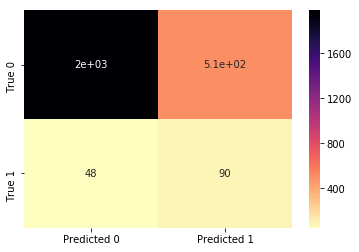

In [43]:
params  = {
    'lr__penalty': ['l1','l2'],
   'lr__C': np.linspace(2.5,3.5,4)
}

gs_bal = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc') # inputs: model, parameters to search over

gs_bal.fit(X_train_bal, y_train_bal['WnvPresent'])

print('GS best ROC AUC score:',gs_bal.best_score_) # best cv score
print('GS best params:',gs_bal.best_params_)
print('')

y_hat_train_bal = gs_bal.predict(X_train_bal)
print('Train accuracy:', accuracy_score(y_train_bal, y_hat_train_bal))
y_hat_bal = gs_bal.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_hat_bal))

print('')
print('Test ROC AUC:',gs_bal.score(X_test, y_test['WnvPresent']))
print('Test confusion matrix:')
sns.heatmap(confusion_matrix(y_test, y_hat_bal), annot=True, cmap='magma_r', 
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1']);

In [44]:
# look at parameters
betas_bal = gs_bal.best_estimator_.named_steps['lr'].coef_

coef_df_bal = pd.DataFrame(betas_bal.T, columns = ['coefs'], index = X_train_bal.columns)

coef_abs_df_bal = pd.DataFrame(coef_df_bal['coefs'].map(lambda x: abs(x)).sort_values(ascending=False))
coef_abs_df_bal['sign'] = coef_df_bal['coefs'].map(lambda x: 1 if x>0 else -1)
coef_abs_df_bal.reset_index(inplace=True)

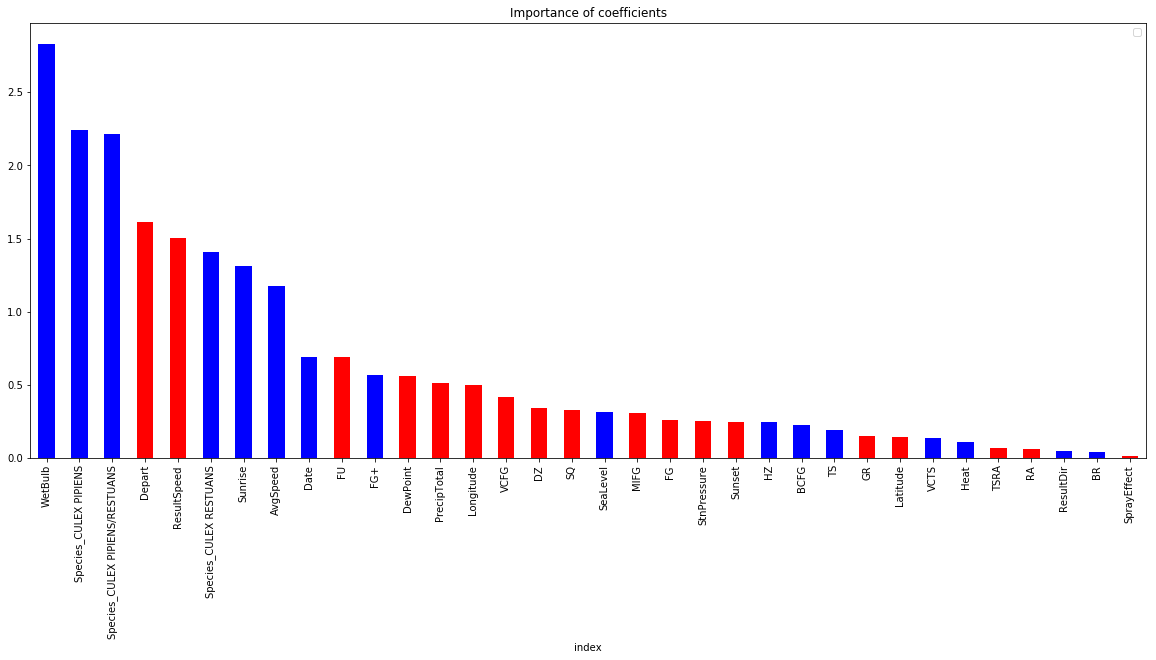

In [47]:
colors = coef_abs_df_bal['sign'].map(lambda x: 'blue' if x==1 else 'red')
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
coef_abs_df_bal.plot(x='index',y='coefs', kind='bar', color=colors, ax=ax)
ax.legend('')
ax.set_title('Importance of coefficients');